In [1]:
from datetime import date
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
df = pd.read_csv("../Resources/btcjoin.csv", parse_dates=['date'])
df = df.drop(columns=['volume','change', 'low', 'high', 'open'])
df = df.rename(columns={"value": "wallets"})
df['price']=df['price'].str.replace(',','')
df['price']=df['price'].astype("float")
df.dtypes

#https://dcresearch.medium.com/metcalfes-law-and-bitcoin-s-value-2b99c7efd1fa

date       datetime64[ns]
price             float64
wallets             int64
address           float64
mined             float64
dtype: object

In [2]:
df['Metcafe']=df['address']**2
# df["Metcafe"] = df["Metcafe"].map("{:.1f}".format)
df['value'] = df['Metcafe']/df['mined']
df["value"] = df["value"].map("{:.2f}".format)
df['value']=df['value'].astype("float")
df['networkvalue'] = df["price"] - df["value"]
df.dtypes


date            datetime64[ns]
price                  float64
wallets                  int64
address                float64
mined                  float64
Metcafe                float64
value                  float64
networkvalue           float64
dtype: object

In [3]:
df

,date,price,wallets,address,mined,Metcafe,value,networkvalue
0,2010-09-25,0.1,2,656.0,4109450.00,4.303360e+05,0.10,0.00
1,2010-09-26,0.1,2,444.0,4110750.00,1.971360e+05,0.05,0.05
2,2010-09-27,0.1,2,1070.0,4132150.00,1.144900e+06,0.28,-0.18
3,2010-09-28,0.1,2,1503.0,4133200.00,2.259009e+06,0.55,-0.45
4,2010-09-29,0.1,2,1049.0,4148050.00,1.100401e+06,0.27,-0.17
...,...,...,...,...,...,...,...,...
4381,2022-10-21,19162.6,84879615,924681.0,19185681.25,8.550350e+11,44566.31,-25403.71
4382,2022-10-22,19204.8,84888147,830404.0,19186618.75,6.895708e+11,35940.19,-16735.39
4383,2022-10-23,19571.2,84893809,804140.0,19187600.00,6.466411e+11,33700.99,-14129.79
4384,2022-10-24,19331.5,84902680,919344.0,19188556.25,8.451934e+11,44046.74,-24715.24


In [4]:
df_train = df[['date', 'price']]
df_train = df_train.rename(columns = {"date":"ds", "price":"y"})

m = Prophet()
m.fit(df_train)

n_years =2
period = n_years * 365
future = m.make_future_dataframe(periods = period)
forecast = m.predict(future)

19:38:08 - cmdstanpy - INFO - Chain [1] start processing
19:38:08 - cmdstanpy - INFO - Chain [1] done processing


In [5]:
forecast[['ds', 'yhat', 'yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
5111,2024-10-20,67579.622795,57751.576885,77223.695356
5112,2024-10-21,67786.517389,57743.896645,77283.723736
5113,2024-10-22,67956.169026,58175.143038,77423.342108
5114,2024-10-23,68193.892712,58261.286959,77790.413490
5115,2024-10-24,68339.782496,58359.593003,77650.035221


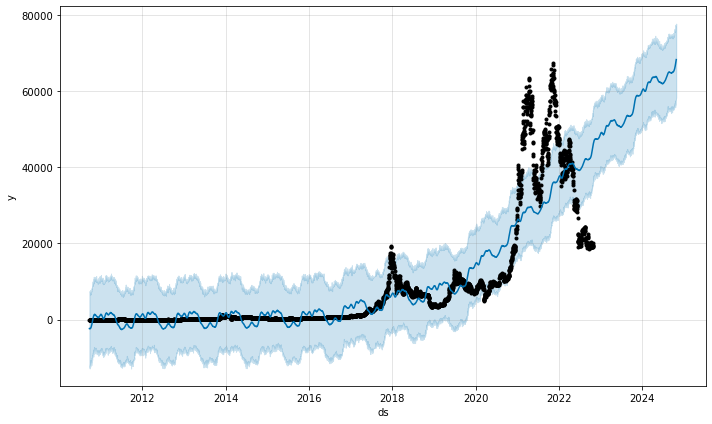

In [6]:
fig1 = m.plot(forecast)
plt.savefig("../Website/images/autocorrelationprices.png", dpi = 72)

In [7]:
df_train = df[['date', 'price']]
df_train = df_train.rename(columns = {"date":"ds", "price":"y"})

m = Prophet()
m.fit(df_train)

# instantiate the model and set parameters
model = Prophet()

# fit the model to historical data
model.fit(df_train);

19:38:10 - cmdstanpy - INFO - Chain [1] start processing
19:38:11 - cmdstanpy - INFO - Chain [1] done processing
19:38:11 - cmdstanpy - INFO - Chain [1] start processing
19:38:12 - cmdstanpy - INFO - Chain [1] done processing


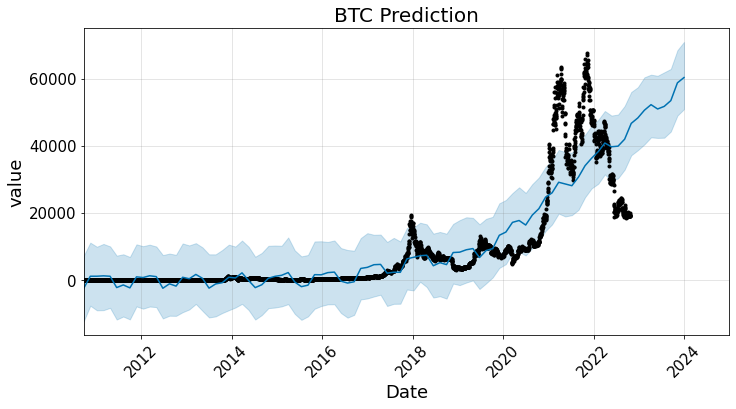

In [8]:
# Create a data frame that lists dates from Oct - Dec 2017
insample = pd.DataFrame(pd.date_range("2010-09-25", "2024-01-01", periods=92))

# Change the column name
insample.columns = ['ds']

# in-sample prediction
prediction = model.predict(insample)

# Plot
fig = model.plot(prediction, figsize=(10,5))
ax = fig.gca()
ax.set_title("BTC Prediction", size=20)
ax.set_xlabel("Date", size=18)
ax.set_ylabel("value", size=18)
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', rotation=45, labelsize=15)
ax.set_xlim(pd.to_datetime(['2010-09-25', '2024-12-31'])) 
plt.show();

In [46]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(name="Actual", x=df_train['ds'], y=df_train['y'], legendrank=4))
fig.add_trace(go.Scatter(name="Upper Bound Prediction", x=prediction['ds'], y=prediction['yhat'], legendrank=2))
fig.add_trace(go.Scatter(name="Lower Bound Prediction", x=prediction['ds'], y=prediction['yhat_lower'], legendrank=1))

fig.update_xaxes(
    rangeslider_visible = True,
    rangeselector = dict(
        buttons = list([
            dict(count = 1, label = "1m", step = "month", stepmode = "backward"),
            dict(count = 6, label = "6m", step = "month", stepmode = "backward"),
            dict(count = 1, label = "YTD", step = "year", stepmode = "todate"),
            dict(count = 1, label = "1y", step = "year", stepmode = "backward"),
            dict(step = "all")
        ])
    )
)
fig.update_layout(title_text='Bitcoin Prices and Date Prediction')
fig.update_yaxes(ticklabelposition="inside top", title="Bitcoin Prices")
fig.update_xaxes(ticklabelposition="inside top", title="Date")
fig.update_yaxes(nticks=15)
fig.update_xaxes(nticks=20)

fig.show()
fig.write_html('../Website/images/prices.html')

In [10]:
import plotly.express as px

fig = px.line(x=df['date'], y=df['networkvalue'])


fig.update_xaxes(
    rangeslider_visible = True,
    rangeselector = dict(
        buttons = list([
            dict(count = 1, label = "1m", step = "month", stepmode = "backward"),
            dict(count = 6, label = "6m", step = "month", stepmode = "backward"),
            dict(count = 1, label = "YTD", step = "year", stepmode = "todate"),
            dict(count = 1, label = "1y", step = "year", stepmode = "backward"),
            dict(step = "all")
        ])
    )
)


fig.show()

In [11]:
## Supervised Learning
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter

In [12]:
df['status'] = df['networkvalue'].apply(lambda x: '1' if x > 0 else '0')


In [13]:
# Create our features
X = df.drop(columns="status")
X = pd.get_dummies(X)

# Create our target
X = df.drop(columns="date")
y = df['status']

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
   y, random_state=1, stratify=y)
   

In [15]:
## Logistic Regression

In [16]:
 from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier

LogisticRegression()

In [17]:
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

LogisticRegression()

In [18]:
classifier.fit(X_train, y_train)

LogisticRegression()

In [19]:
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

LogisticRegression()

In [20]:
print(f"Training Data Score: {classifier.score(X_train, y_train)}")
print(f"Testing Data Score: {classifier.score(X_test, y_test)}")

Training Data Score: 0.9388871997567649
Testing Data Score: 0.9389243391066545


In [21]:
# print(f'Actual:\t\t{list(y_test[:1000])}')
# print(f'Predicted:\t{list(classifier.predict(X_test[:1000]))}')

In [22]:
#Random Forest

In [23]:
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.datasets import make_classification
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [24]:
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [25]:
clf = RandomForestClassifier(random_state=1, n_estimators=500).fit(X_train_scaled, y_train)
print(f'Training Score: {clf.score(X_train_scaled, y_train)}')
print(f'Testing Score: {clf.score(X_test_scaled, y_test)}')

Training Score: 1.0
Testing Score: 1.0


In [26]:
from sklearn.feature_selection import SelectFromModel

In [27]:
 from sklearn.feature_selection import SelectFromModel
sel = SelectFromModel(clf)
sel.fit(X_train_scaled, y_train)
sel.get_support()

array([False, False, False, False, False, False,  True,  True])

In [28]:
X_selected_train, X_selected_test, y_train, y_test = train_test_split(sel.transform(X), y, random_state=1)
scaler = StandardScaler().fit(X_selected_train)
X_selected_train_scaled = scaler.transform(X_selected_train)
X_selected_test_scaled = scaler.transform(X_selected_test)

c:\Users\16474\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning:

X has feature names, but SelectFromModel was fitted without feature names



In [29]:
clf = LogisticRegression().fit(X_train_scaled, y_train)
print(f'Training Score: {clf.score(X_train_scaled, y_train)}')
print(f'Testing Score: {clf.score(X_test_scaled, y_test)}')

Training Score: 0.9370629370629371
Testing Score: 0.9443938012762079


In [30]:
#Ensemble

In [31]:
 %matplotlib inline
from matplotlib import pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.utils.random import sample_without_replacement
from sklearn.utils import resample

In [32]:
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [33]:
clf = DecisionTreeClassifier().fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)
cm

array([[967,  69],
       [ 56,   5]], dtype=int64)

In [34]:
 # Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

cm_df

,Predicted 0,Predicted 1
Actual 0,967,69
Actual 1,56,5


In [35]:
print(classification_report(y_test, y_pred)) 

              precision    recall  f1-score   support

           0       0.95      0.93      0.94      1036
           1       0.07      0.08      0.07        61

    accuracy                           0.89      1097
   macro avg       0.51      0.51      0.51      1097
weighted avg       0.90      0.89      0.89      1097



In [36]:
print(f'Training Score: {clf.score(X_train_scaled, y_train)}')
print(f'Testing Score: {clf.score(X_test_scaled, y_test)}')
print(classification_report(y_test, y_pred)) 

Training Score: 1.0
Testing Score: 0.886052871467639
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      1036
           1       0.07      0.08      0.07        61

    accuracy                           0.89      1097
   macro avg       0.51      0.51      0.51      1097
weighted avg       0.90      0.89      0.89      1097



In [37]:
##Bagging

In [38]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=1, n_estimators=3000).fit(X_train_scaled, y_train)
print(f'Training Score: {clf.score(X_train_scaled, y_train)}')
print(f'Testing Score: {clf.score(X_test_scaled, y_test)}')
print(classification_report(y_test, y_pred)) 

Training Score: 1.0
Testing Score: 0.9416590701914311
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      1036
           1       0.07      0.08      0.07        61

    accuracy                           0.89      1097
   macro avg       0.51      0.51      0.51      1097
weighted avg       0.90      0.89      0.89      1097



In [39]:
##Extremely Random Trees"

In [40]:
 from sklearn.ensemble import ExtraTreesClassifier
clf = ExtraTreesClassifier(random_state=1, n_estimators=3000).fit(X_train_scaled, y_train)
print(f'Training Score: {clf.score(X_train_scaled, y_train)}')
print(f'Testing Score: {clf.score(X_test_scaled, y_test)}')
print(classification_report(y_test, y_pred)) 

Training Score: 1.0
Testing Score: 0.9279854147675478
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      1036
           1       0.07      0.08      0.07        61

    accuracy                           0.89      1097
   macro avg       0.51      0.51      0.51      1097
weighted avg       0.90      0.89      0.89      1097



In [41]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(random_state=1, n_estimators=3000, base_estimator=DecisionTreeClassifier(max_depth=2)).fit(X_train_scaled, y_train)
print(f'Training Score: {clf.score(X_train_scaled, y_train)}')
print(f'Testing Score: {clf.score(X_test_scaled, y_test)}')
print(classification_report(y_test, y_pred)) 

Training Score: 1.0
Testing Score: 0.9170464904284412
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      1036
           1       0.07      0.08      0.07        61

    accuracy                           0.89      1097
   macro avg       0.51      0.51      0.51      1097
weighted avg       0.90      0.89      0.89      1097



In [42]:
##Neural Network https://towardsdatascience.com/is-it-possible-to-predict-stock-prices-with-a-neural-network-d750af3de50b